In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

In [9]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 

## Preporcess dataset

In [198]:
# Train
dataset_train = pd.read_csv("train.csv")
dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])
dataset_train = dataset_train[['Close','Open','Low','High','Volume']]

In [199]:
# Val
dataset_val = pd.read_csv("val.csv")
dataset_val['Date'] = pd.to_datetime(dataset_val['Date'])
dataset_val = dataset_val[['Close','Open','Low','High','Volume']]

In [200]:
#feature extend
#Alpha002: the balance of long and short power
dataset_train['alpha002'] = (dataset_train['Close']-dataset_train['Low'])-(dataset_train['High']-dataset_train['Close'])/(dataset_train['High']-dataset_train['Low'])
dataset_val['alpha002'] = (dataset_val['Close']-dataset_val['Low'])-(dataset_val['High']-dataset_val['Close'])/(dataset_val['High']-dataset_val['Low'])

In [201]:
#Alpha003: unusual transaction
dataset_train['alpha003'] = dataset_train['Volume']
dataset_val['alpha003'] = dataset_val['Volume']

for i in range(1, (len(dataset_train['Close']-1))):
    dataset_train.loc[i, 'alpha003']  = 2*dataset_train.loc[i, 'Volume']/(dataset_train.loc[i, 'Volume']+dataset_train.loc[i-1, 'Volume'])+1
dataset_train.loc[0, 'alpha003'] = dataset_train.loc[1, 'alpha003']

for i in range(1, (len(dataset_val['Close']-1))):
   dataset_val.loc[i, 'alpha003']  = 2*dataset_val.loc[i, 'Volume']/(dataset_val.loc[i, 'Volume']+dataset_val.loc[i-1, 'Volume'])+1
dataset_val.loc[0, 'alpha003'] = dataset_val.loc[1, 'alpha003']

C:\Users\appre\AppData\Local\Temp\ipykernel_27876\1241173342.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.933987397452756' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset_train.loc[i, 'alpha003']  = 2*dataset_train.loc[i, 'Volume']/(dataset_train.loc[i, 'Volume']+dataset_train.loc[i-1, 'Volume'])+1
C:\Users\appre\AppData\Local\Temp\ipykernel_27876\1241173342.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.0010132320601635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset_val.loc[i, 'alpha003']  = 2*dataset_val.loc[i, 'Volume']/(dataset_val.loc[i, 'Volume']+dataset_val.loc[i-1, 'Volume'])+1


In [202]:
#Alpha004: unusual open price detection
dataset_train['alpha004'] = dataset_train['Close']
dataset_val['alpha004'] = dataset_val['Close']

for i in range(1, (len(dataset_train['Close']-1))):
    dataset_train.loc[i, 'alpha004']  = dataset_train.loc[i, 'Open']/dataset_train.loc[i-1, 'Close']+1
dataset_train.loc[0, 'alpha004'] = dataset_train.loc[1, 'alpha004']

for i in range(1, (len(dataset_val['Close']-1))):
   dataset_val.loc[i, 'alpha004']  = dataset_val.loc[i, 'Open']/dataset_val.loc[i-1, 'Close']+1
dataset_val.loc[0, 'alpha004'] = dataset_val.loc[1, 'alpha004']

In [203]:
#Alpha005: unusual price volitary
dataset_train['alpha005'] = dataset_train['Close']
dataset_val['alpha005'] = dataset_val['Close']

for i in range(1, (len(dataset_train['Close']-1))):
    dataset_train.loc[i, 'alpha005']  = (dataset_train.loc[i, 'High']-dataset_train.loc[i, 'Low'])/dataset_train.loc[i-1, 'Low']+1
dataset_train.loc[0, 'alpha005'] = dataset_train.loc[1, 'alpha005']

for i in range(1, (len(dataset_val['Close']-1))):
   dataset_val.loc[i, 'alpha005']  = (dataset_val.loc[i, 'High']-dataset_val.loc[i, 'Low'])/dataset_val.loc[i-1, 'Low']+1
dataset_val.loc[0, 'alpha005'] = dataset_val.loc[1, 'alpha005']

In [204]:
dataset_train = dataset_train.drop(columns='Low')
dataset_train = dataset_train.drop(columns='High')
dataset_train = dataset_train.drop(columns='Open')
dataset_val = dataset_val.drop(columns='Low')
dataset_val = dataset_val.drop(columns='High')
dataset_val = dataset_val.drop(columns='Open')

In [205]:
dataset_val.tail()

,Close,Volume,alpha002,alpha003,alpha004,alpha005
801,2966.149902,2559270000,2.534195,1.833558,1.998498,1.003341
802,2995.679932,3345090000,21.813669,2.133091,2.002515,1.010014
803,2989.689941,3230320000,3.853844,1.982546,1.997997,1.004150
804,2997.949951,3103470000,5.533240,1.979972,2.003706,1.005527
805,2986.199951,3268970000,9.307365,2.025971,1.999630,1.007918


In [206]:
dataset_train.shape, dataset_val.shape

((2416, 6), (806, 6))

In [207]:
num_train = dataset_train.shape[0]
num_val = dataset_val.shape[0]
mat_train = dataset_train.values
mat_val = dataset_val.values
mat_total = []

for index in range(num_train): 
    mat_total.append(mat_train[index])
for index in range(num_val):
    mat_total.append(mat_val[index])

In [208]:
min_max_scaler = preprocessing.MinMaxScaler()
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
minmax_total = min_max_scaler.fit_transform(mat_total)
total = pd.DataFrame(minmax_total, columns=dataset_train.columns)

In [209]:
train = total.head(num_train)
val = total.tail(num_val)

In [210]:
train.tail()

,Close,Volume,alpha002,alpha003,alpha004,alpha005
2411,0.636058,0.237843,0.041053,0.441262,0.473650,0.037141
2412,0.630180,0.270702,0.080804,0.536389,0.466676,0.080905
2413,0.633057,0.264737,0.100148,0.491959,0.477183,0.033948
2414,0.633253,0.257323,0.047068,0.490200,0.476261,0.025009
2415,0.641179,0.252901,0.123486,0.493494,0.551103,0.045588


## Preprocess input

In [245]:
window = 2

In [246]:
#train
input_train = train
seq_len = window
num_feature_train = len(input_train.columns)
mat_train = input_train.values
sequence_length = seq_len + 1
sli_train = []

for index in range(len(mat_train) - sequence_length): 
    sli_train.append(mat_train[index: index + sequence_length])
sli_train = np.array(sli_train)

In [247]:
x_train = sli_train[:, :-1]
y_train = sli_train[:, -1][:, 0]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_feature_train))

In [248]:
#val
input_val = val
num_feature_train = len(input_val.columns)
mat_val = input_val.values
sli_val = []

for index in range(len(mat_val) - sequence_length): 
    sli_val.append(mat_val[index: index + sequence_length])
sli_val = np.array(sli_val)

In [249]:
x_test = sli_val[:, :-1]
y_test = sli_val[:, -1][:, 0]
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_feature_train))

In [250]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2413, 2, 6) (2413,) (803, 2, 6) (803,)


## Parameters

In [251]:
input_size = len(dataset_train.iloc[1, :])
lstm_units = 64  # the number of hidden neural network
dropout = 0.01
epoch = 20

## Construct model

In [252]:
inputs = Input(shape=(window, input_size))
model = Conv1D(filters=lstm_units, kernel_size=1, activation='sigmoid')(inputs)
model = MaxPooling1D(pool_size=window)(model)
model = Dropout(dropout)(model)
model = Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(model)
attention = Dense(lstm_units * 2, activation='sigmoid', name='attention_vec')(model)
model = Multiply()([model, attention])
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#loss='mse'：mean_squared_error
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 2, 6)]               0         []                            
                                                                                                  
 conv1d_9 (Conv1D)           (None, 2, 64)                448       ['input_10[0][0]']            
                                                                                                  
 max_pooling1d_9 (MaxPoolin  (None, 1, 64)                0         ['conv1d_9[0][0]']            
 g1D)                                                                                             
                                                                                                  
 dropout_9 (Dropout)         (None, 1, 64)                0         ['max_pooling1d_9[0][0]'

In [253]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=300, shuffle=False,
                    validation_data=(X_test, y_test))

Epoch 1/20
9/9 [==============================] - 3s 77ms/step - loss: 0.0296 - accuracy: 4.1442e-04 - val_loss: 0.1165 - val_accuracy: 0.0012
Epoch 2/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0602 - accuracy: 0.0000e+00 - val_loss: 0.1481 - val_accuracy: 0.0000e+00
Epoch 3/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0412 - accuracy: 4.1442e-04 - val_loss: 0.2492 - val_accuracy: 0.0000e+00
Epoch 4/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0277 - accuracy: 4.1442e-04 - val_loss: 0.2289 - val_accuracy: 0.0000e+00
Epoch 5/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0262 - accuracy: 4.1442e-04 - val_loss: 0.1900 - val_accuracy: 0.0000e+00
Epoch 6/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0311 - accuracy: 4.1442e-04 - val_loss: 0.1925 - val_accuracy: 0.0000e+00
Epoch 7/20
9/9 [==============================] - 0s 12ms/step - loss: 0.0309 - accuracy: 4.1442e-04 - val_loss: 0.2069 - 

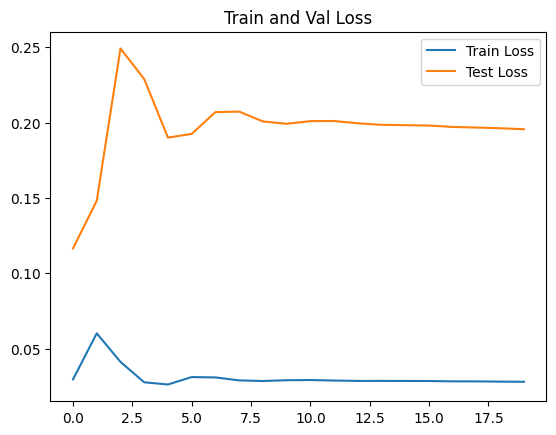

In [254]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

76/76 [==============================] - 1s 1ms/step
(2413,) (2413,) (2413, 2)


Text(0.5, 1.0, 'Train Data')

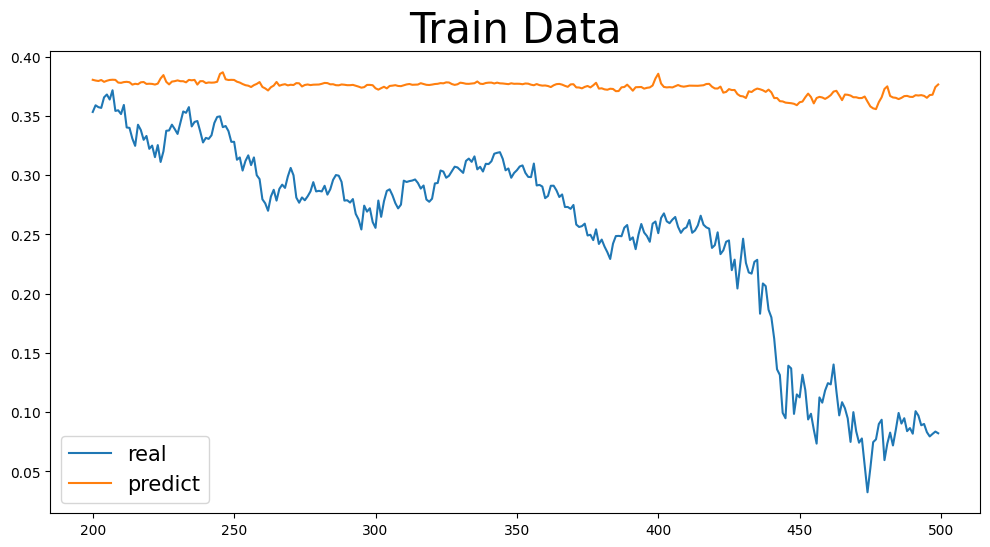

In [255]:
y_train_predict = model.predict(X_train)
y_train_predict = y_train_predict[:, 0]
draw = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_train_predict)], axis=1)
# print(y_train,y_train_predict,draw)
print(y_train.shape,y_train_predict.shape,draw.shape)
draw.iloc[200:500, 0].plot(figsize=(12, 6))
draw.iloc[200:500, 1].plot(figsize=(12, 6))
plt.legend(('real', 'predict'), fontsize='15')
plt.title("Train Data", fontsize='30')

26/26 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Test Data')

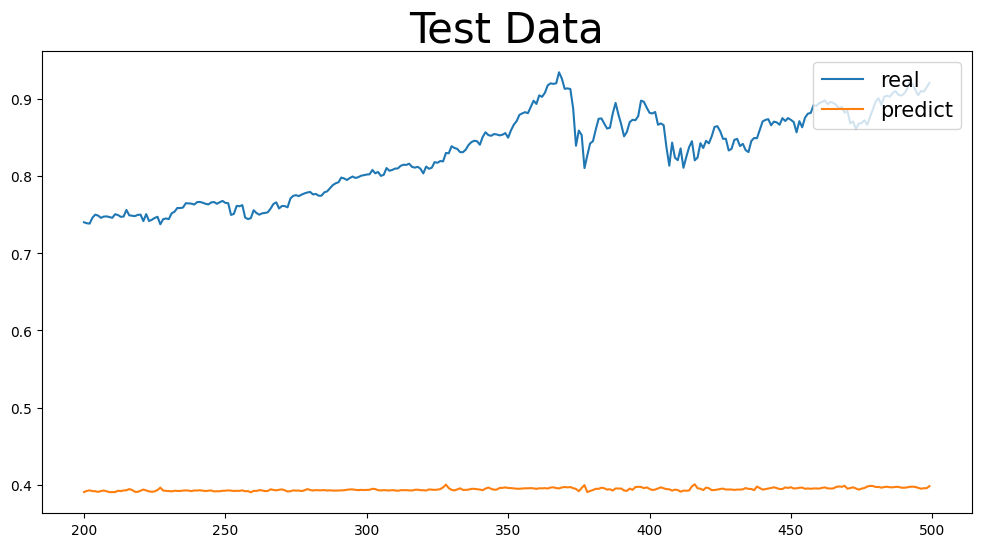

In [256]:
y_test_predict = model.predict(X_test)
y_test_predict = y_test_predict[:, 0]
draw = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_test_predict)], axis=1);
draw.iloc[200:500, 0].plot(figsize=(12, 6))
draw.iloc[200:500, 1].plot(figsize=(12, 6))
plt.legend(('real', 'predict'), loc='upper right', fontsize='15')
plt.title("Test Data", fontsize='30') 

In [242]:
#输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def up_down_accuracy(y_true, y_pred):
    y_var_test = y_true[1:] - y_true[:len(y_true) - 1]  #实际涨跌
    y_var_predict = y_pred[1:] - y_pred[:len(y_pred) - 1]  #原始涨跌
    txt = np.zeros(len(y_var_test))
    for i in range(len(y_var_test - 1)):  #计算数量
        txt[i] = np.sign(y_var_test[i]) == np.sign(y_var_predict[i])
    result = sum(txt) / len(txt)
    return result


print('训练集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
#绝对值误差
print(mean_squared_error(y_train_predict, y_train))
#方差
print(mape(y_train_predict, y_train))
#均值
print(up_down_accuracy(y_train_predict, y_train))
#涨跌准确率
print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test))
print(mape(y_test_predict, y_test))
print(up_down_accuracy(y_test_predict, y_test))

训练集上的MAE/MSE/MAPE/涨跌准确率
0.1271870735234637
0.021040636367748004
34.23560128739974
0.47088186356073214
测试集上的MAE/MSE/MAPE/涨跌准确率


ValueError: Found input variables with inconsistent numbers of samples: [800, 795]